In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Load dataset
dataset_path = "/home/yadagiri/train_dataset.csv"
df = pd.read_csv(dataset_path)

X = list(df['text'])
#y = np.asarray(d1[d1.columns[1:]])
y_data = df[df.columns[12:13]]
y = y_data.values
######### Label Encoding for y_train & y_test################
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y
# Split dataset into train and validation sets
train_X, val_X, train_y, val_y = train_test_split(X,y, test_size=0.1, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # import pdb;pdb.set_trace()
        text = self.texts[idx]
        label = self.labels[idx]  # Convert label to integer
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Assuming 2 classes for binary classification
batch_size = 32
epochs = 3
# Create DataLoader for train and validation sets
train_dataset = CustomDataset(train_X, train_y, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_X, val_y, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define optimizer and loss function
# optimizer = AdamW(model.parameters(), lr=learning_rate)
# criterion = torch.nn.CrossEntropyLoss()

# Create DataLoader for train and validation sets
# train_dataset = CustomDataset(train_df['text'], train_df['binary_label'], tokenizer)
# val_dataset = CustomDataset(val_df['text'], val_df['binary_label'], tokenizer)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define training parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(model.parameters(), lr=2e-5)



2024-05-01 09:25:59.254567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 09:25:59.254755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 09:26:00.555092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 09:26:04.086350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 09:26:39.078953: W tensorflow/comp

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Initialize empty lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0
    train_predicted_labels = []
    train_true_labels = []
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct_train_preds += (predicted == labels).sum().item()
        total_train_preds += labels.size(0)
        train_predicted_labels.extend(predicted.cpu().numpy())
        train_true_labels.extend(labels.cpu().numpy())

    # Calculate training accuracy and loss for the epoch
    train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_precision = precision_score(train_true_labels, train_predicted_labels, average='weighted')
    train_recall = recall_score(train_true_labels, train_predicted_labels, average='weighted')
    train_f1 = f1_score(train_true_labels, train_predicted_labels, average='weighted')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

    # Validation loop
    model.eval()
    epoch_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0
    val_predicted_labels = []
    val_true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            correct_val_preds += (predicted == labels).sum().item()
            total_val_preds += labels.size(0)
            val_predicted_labels.extend(predicted.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Calculate validation accuracy and loss for the epoch
    val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds
    val_precision = precision_score(val_true_labels, val_predicted_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_predicted_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_predicted_labels, average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Train Precision: {train_precision}, Train Recall: {train_recall}, Train F1: {train_f1}")
    print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val F1: {val_f1}")


Epoch 1/3, Train Loss: 0.15330939223085754, Train Accuracy: 0.9501600365797896, Train Precision: 0.9444395371060069, Train Recall: 0.9501600365797896, Train F1: 0.9427786522874205
Val Loss: 0.06266258111664731, Val Accuracy: 0.9786008230452675, Val Precision: 0.9780683320873285, Val Recall: 0.9786008230452675, Val F1: 0.9782515964978802
Epoch 2/3, Train Loss: 0.046422895490687496, Train Accuracy: 0.9832647462277092, Train Precision: 0.9829348277222978, Train Recall: 0.9832647462277092, Train F1: 0.9830452407155176
Val Loss: 0.1432582899027406, Val Accuracy: 0.9539094650205762, Val Precision: 0.95467208449117, Val Recall: 0.9539094650205762, Val F1: 0.9442482880894616
Epoch 3/3, Train Loss: 0.020592119593931667, Train Accuracy: 0.9938728852309099, Train Precision: 0.9938317940607987, Train Recall: 0.9938728852309099, Train F1: 0.9938454028832908
Val Loss: 0.21025395634320662, Val Accuracy: 0.9489711934156378, Val Precision: 0.9497453056752878, Val Recall: 0.9489711934156378, Val F1: 0.9

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
# Load test dataset
test_dataset_path = "/home/yadagiri/test_dataset.csv"
test_df = pd.read_csv(test_dataset_path)
X = list(test_df['text'])
# #y = np.asarray(d1[d1.columns[1:]])
y_data = test_df[test_df.columns[12:13]]
y = y_data.values
######### Label Encoding for y_train & y_test################
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
test_df['label'] = label_encoder.fit_transform(test_df['label'])

# Create DataLoader for test set
test_dataset = CustomDataset(test_df['text'], test_df['label'], tokenizer)  # Assuming 'binary_label' is the name of the label column
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate model on test set
model.eval()
test_loss = 0
correct_preds = 0
total_preds = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


Test Loss: 0.20063099013181943, Test Accuracy: 0.9539170506912442
Precision: 0.9527186761229315, Recall: 1.0, F1 Score: 0.9757869249394674
Confusion Matrix:
[[  77  140]
 [   0 2821]]


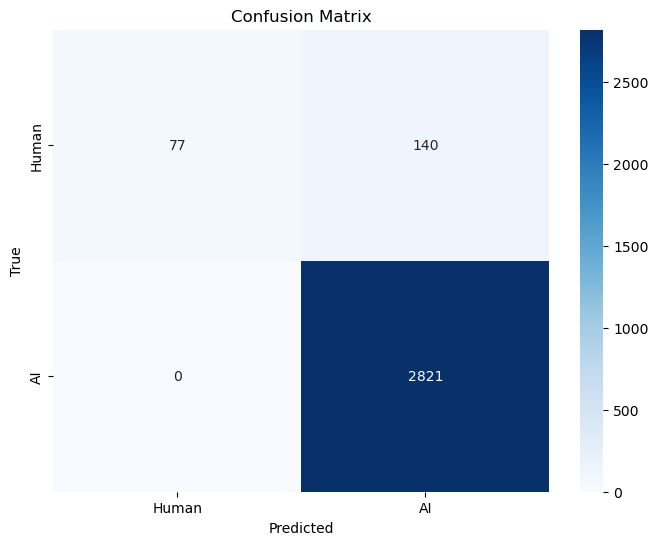

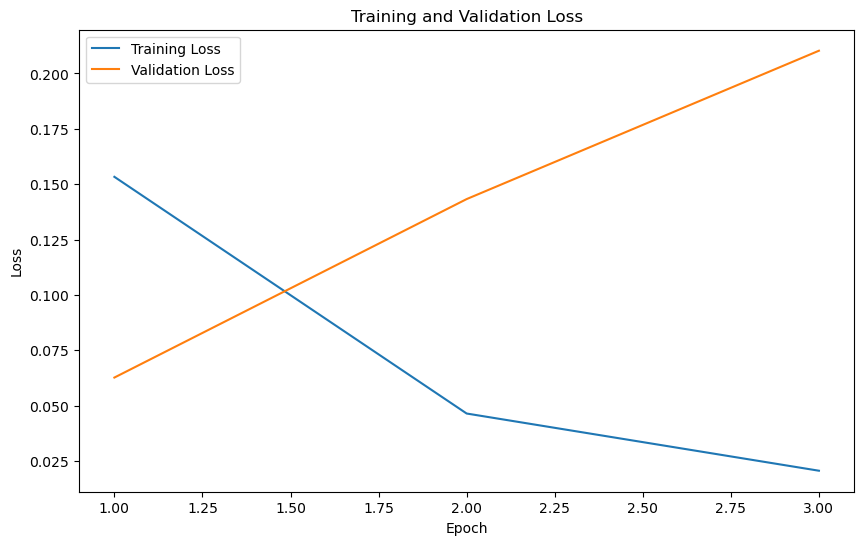

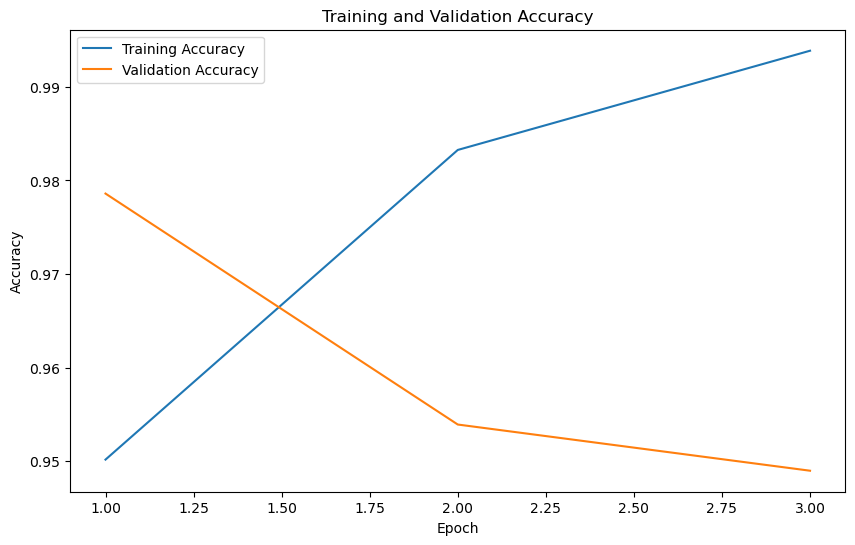

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for test set
y_true = test_df['label']
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
class_names = ['Human', 'AI']  # Rename '0' to 'Hate' and '1' to 'Not Hate'
plot_confusion_matrix(y_true, y_pred, labels=class_names)
# plot_confusion_matrix(y_true, y_pred, labels=['0', '1'])  # Replace labels with actual class labels if different

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
